# Bayesian Marketing Model with PyMC

This notebook demonstrates a simple Bayesian model for daily visitors using PyMC. For now, we use only the visitor counts as the target variable. In the future, we will add temperature as a marketing channel.

In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import os
from pymc_marketing.mmm import YearlyFourier

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Load Cleaned Data
We load the cleaned visitors data from `data/clean/visitors.csv`.

In [47]:
visitor_data_path = os.path.join("..", "data", "clean", "visitors.csv")
df = pd.read_csv(visitor_data_path)
df_weather = pd.read_csv(os.path.join("..", "data", "clean", "weather.csv"))
df_weather["date"] = pd.to_datetime(df_weather.date).dt.date
df["date"] = pd.to_datetime(df["date"]).dt.date
df = df.merge(df_weather, on="date", how="left")
df = df.sort_values("date").reset_index(drop=True)
df.date = pd.to_datetime(df.date)
df = df.set_index("date")
df["visitors"] = df["visitors"].astype(int)
df["visitors_scaled"] = df["visitors"] / df["visitors"].max()
df["day_of_week_idx"] = pd.Categorical(
    df.day_of_week, categories=["ma", "ti", "ke", "to", "pe", "la", "su"]
).codes
df["open"] = True
df.loc[
    pd.date_range("2020-03-17", "2020-05-31", freq="D").append(
        pd.date_range("2020-11-30", "2021-05-02", freq="D")
    ),
    "open",
] = False
df["test_set"] = 0
df.loc["2023-01-01":, "test_set"] = 1
df.head()

,visitors,day_of_week,rain_sum,temperature_2m_max,visitors_scaled,day_of_week_idx,open,test_set
date,,,,,,,,
2018-01-01,437,ma,3.9,4.7215,0.033515,0,True,0
2018-01-02,434,ti,3.3,3.9215,0.033285,1,True,0
2018-01-03,554,ke,2.2,2.6715,0.042488,2,True,0
2018-01-04,653,to,7.9,3.6215,0.050081,3,True,0
2018-01-05,352,pe,3.1,2.7715,0.026996,4,True,0


## Exploratory Data Analysis
Let's visualize the distribution of daily visitors.

/tmp/ipykernel_381731/3793408468.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


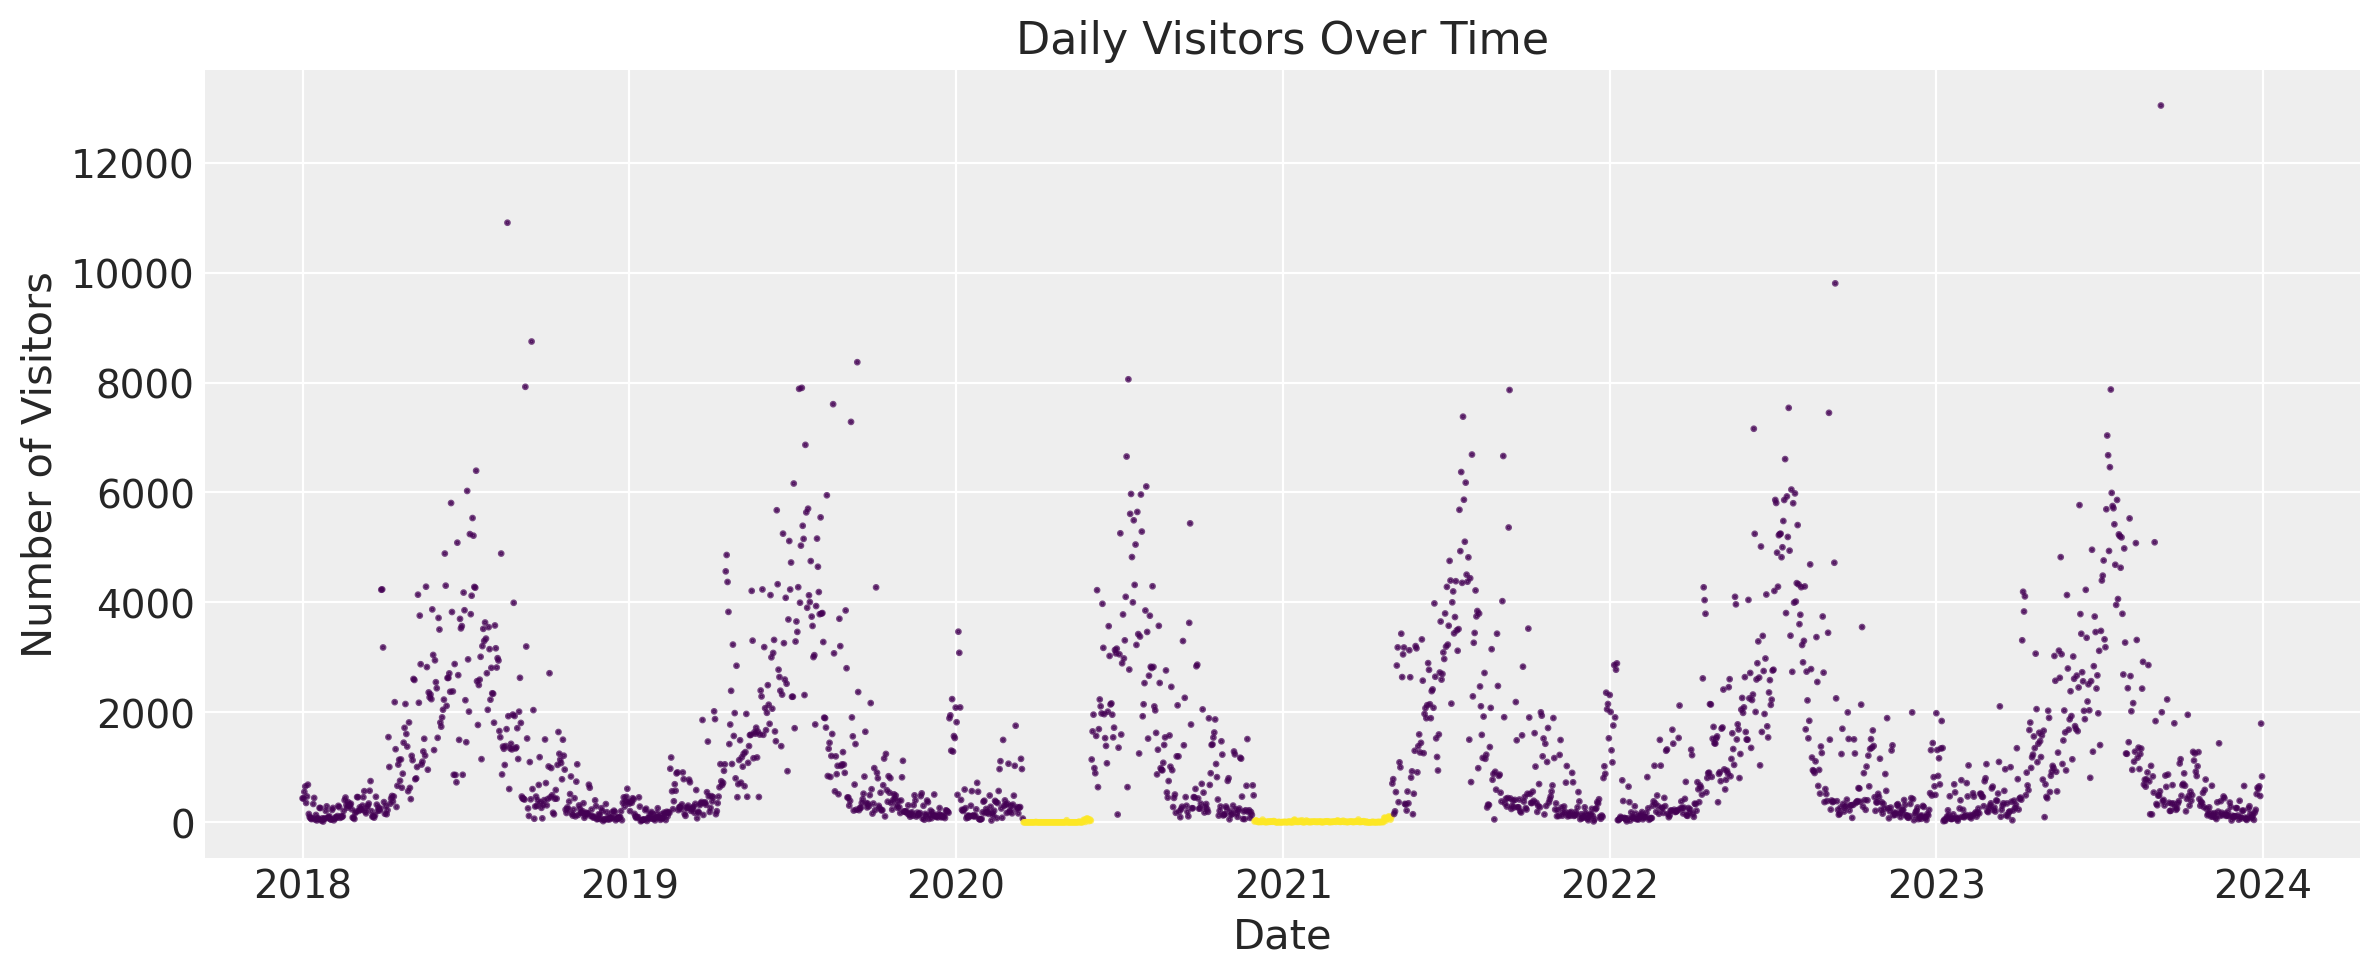

In [49]:
plt.figure(figsize=(12, 5))
plt.scatter(df.index, df["visitors"], alpha=0.7, s=2, c=~df["open"])
plt.title("Daily Visitors Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Visitors")
plt.tight_layout()
plt.show()

/tmp/ipykernel_381731/3425235472.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


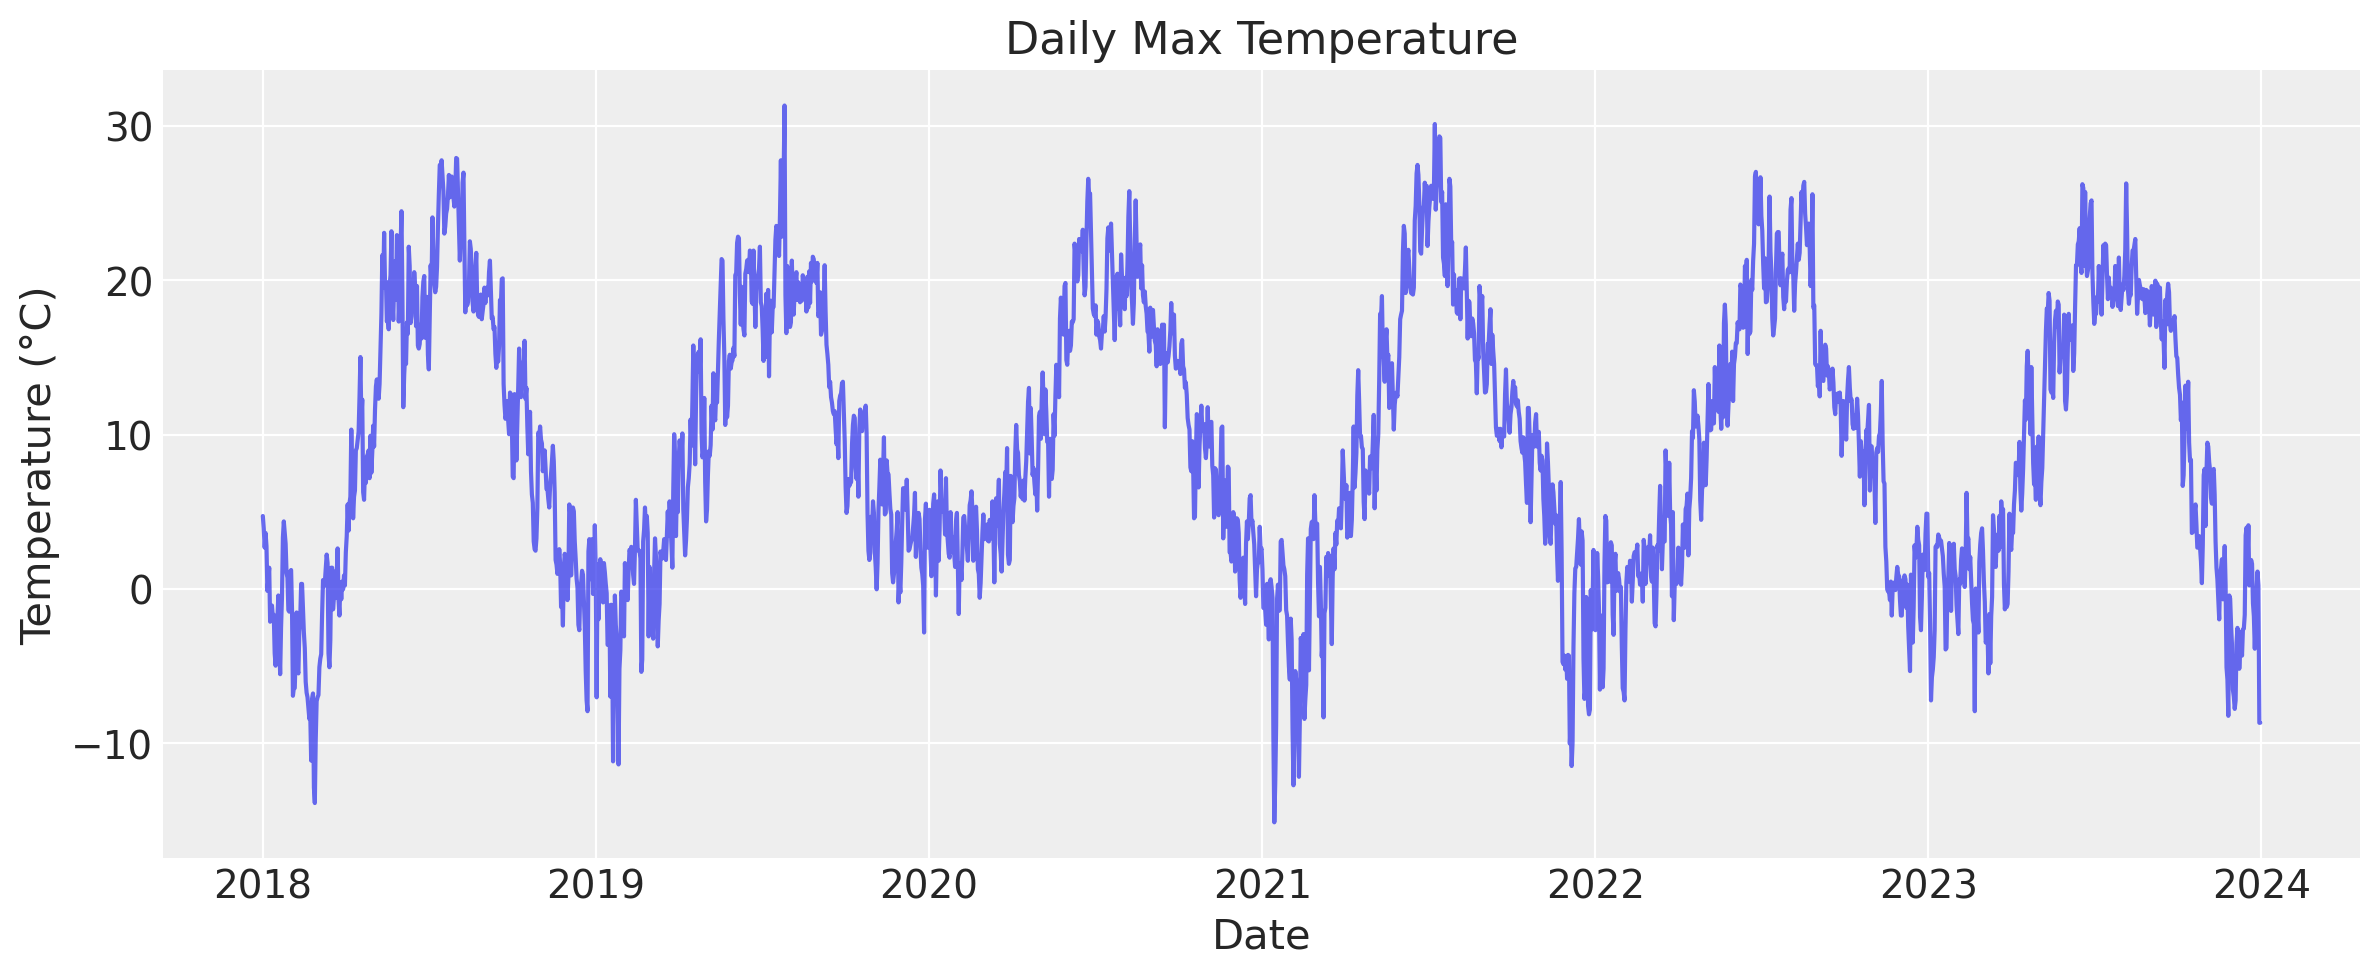

In [55]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["temperature_2m_max"], alpha=0.7)
# plt.scatter(df.index, df['visitors'], alpha=0.7, s=2, c = ~df["open"])
plt.title("Daily Max Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_381731/1436783836.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


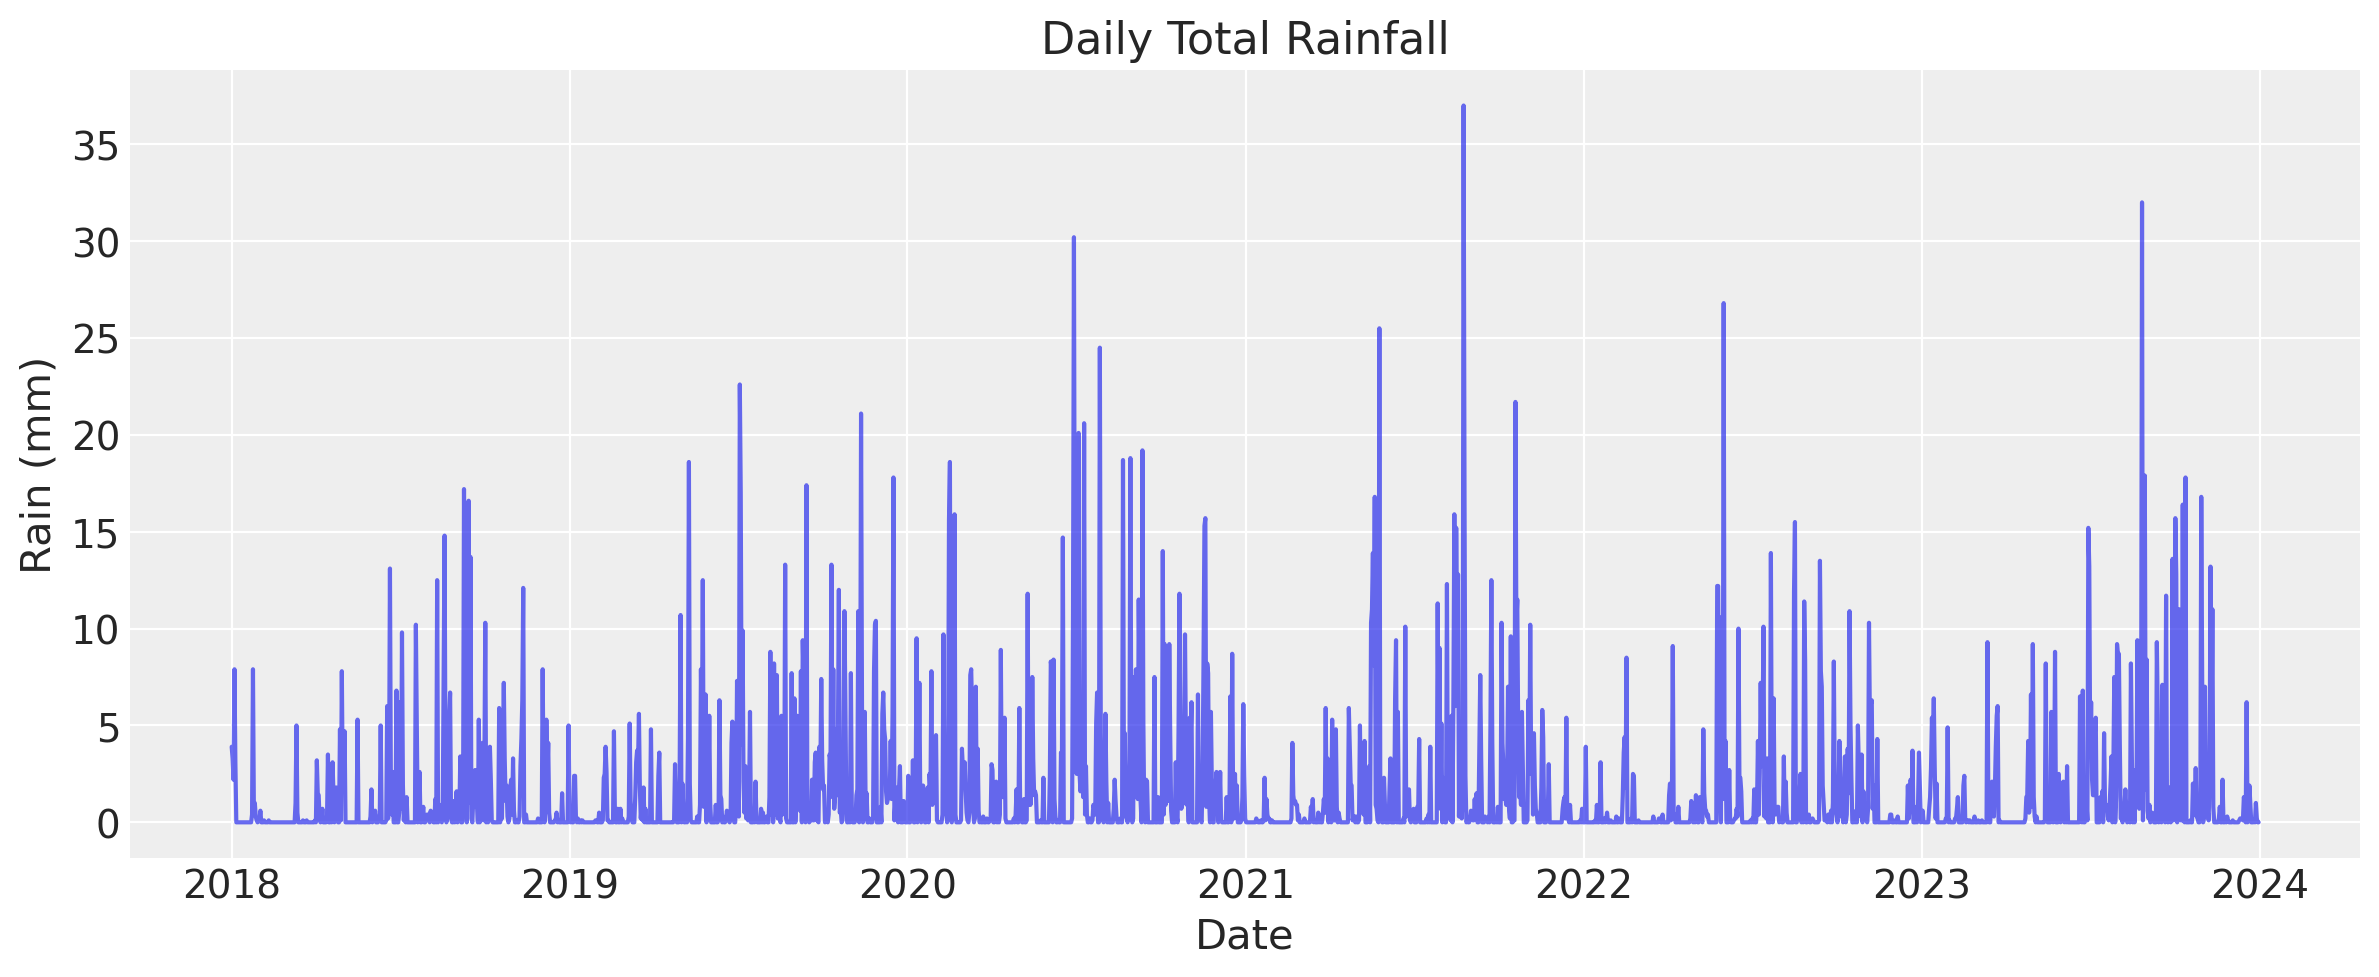

In [57]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["rain_sum"], alpha=0.7)
# plt.scatter(df.index, df['visitors'], alpha=0.7, s=2, c = ~df["open"])
plt.title("Daily Total Rainfall")
plt.xlabel("Date")
plt.ylabel("Rain (mm)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_381731/1210055003.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


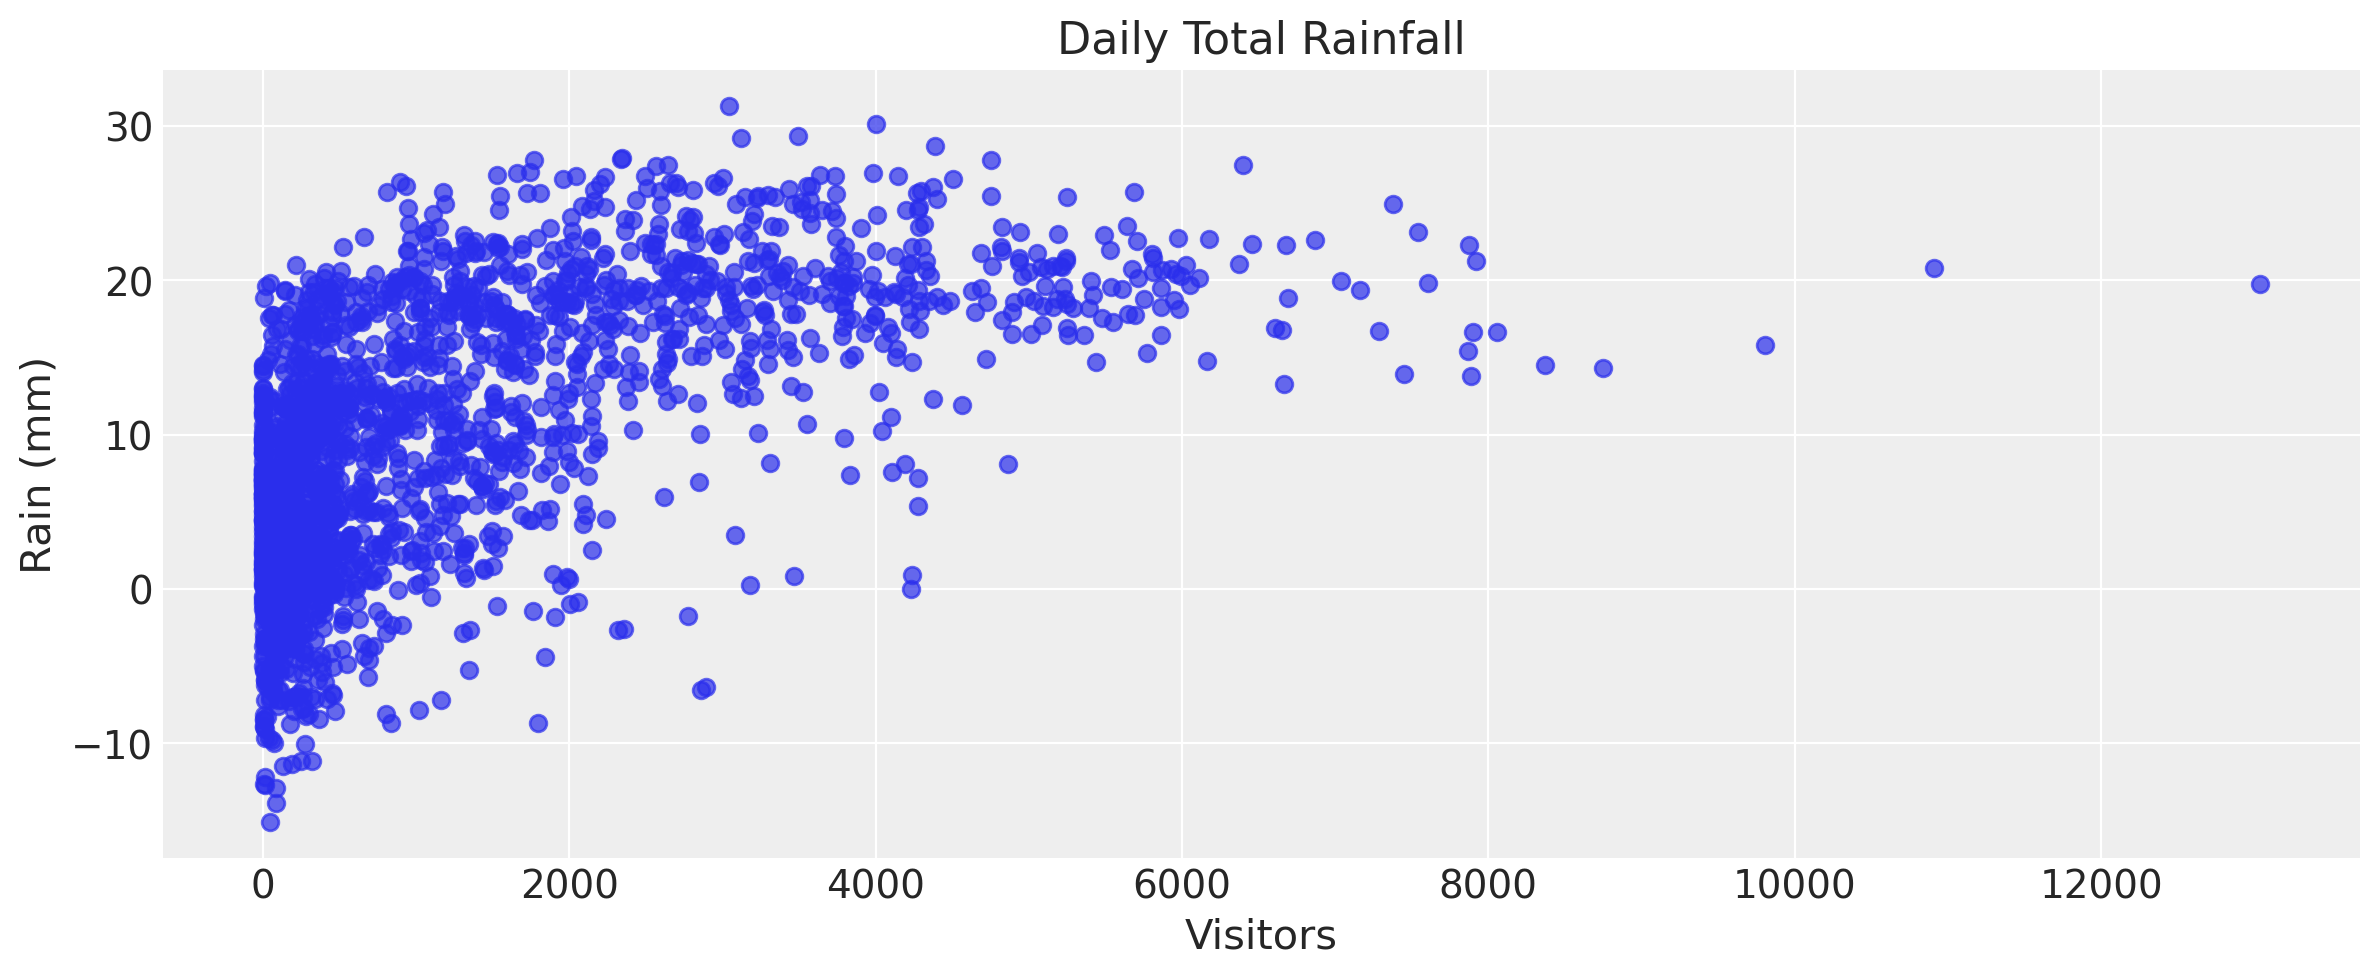

In [61]:
plt.figure(figsize=(12, 5))
plt.scatter(df.visitors, df["temperature_2m_max"], alpha=0.7)
# plt.scatter(df.index, df['visitors'], alpha=0.7, s=2, c = ~df["open"])
plt.title("Daily Total Rainfall")
plt.xlabel("Visitors")
plt.ylabel("Rain (mm)")
plt.tight_layout()
plt.show()

## PyMC Model: Baseline
We will model the number of visitors as a Poisson process with a constant mean. Later, we will add temperature as a predictor.

## PyMC Model: Add Seasonality and Trend
We now extend the model to include a linear trend and a seasonal (yearly) effect using a Fourier series.

In [16]:
yearly = YearlyFourier(n_order=4)
# t = (df.index - df.index.min()).days.to_numpy()
visitors_obs = df.visitors_scaled
visitors_obs.loc[~df.open] = np.nan
coords = {
    "date": df.index.strftime("%Y-%m-%d").tolist(),
    "day_of_week": ["ma", "ti", "ke", "to", "pe", "la", "su"],
}
with pm.Model(coords=coords) as model:
    mu = pm.Normal("mu", mu=0, sigma=0.5)
    week_day = pm.ZeroSumNormal("week_day", dims="day_of_week")
    seasonality = pm.Deterministic(
        "seasonality", yearly.apply(df.index.dayofyear.to_numpy())
    )
    sigma = pm.HalfNormal("sigma")
    visitors_obs = pm.TruncatedNormal(
        "visitors_obs",
        mu=mu + seasonality + week_day[df.day_of_week_idx.values],
        sigma=sigma,
        lower=0,
        observed=visitors_obs,
        dims="date",
    )

/tmp/ipykernel_357147/1943074530.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visitors_obs.loc[~df.open] = np.nan
/home/teemu/repos/korkeasaari/.pixi/envs/default/lib/python3.12/site-packages/pymc/model/core.py:1309: ImputationWarning: Data in visitors_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


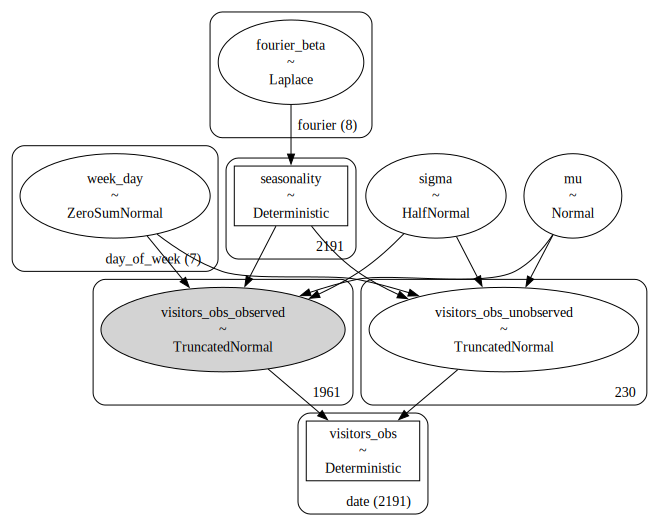

In [17]:
model.to_graphviz()

In [18]:
with model:
    trace = pm.sample(
        1000,
        tune=1000,
        target_accept=0.95,
        random_seed=42,
        cores=4,
        nuts_sampler="nutpie",
    )
    post = pm.sample_posterior_predictive(trace)

/home/teemu/repos/korkeasaari/.pixi/envs/default/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/teemu/repos/korkeasaari/.pixi/envs/default/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.15,31
,2000,0,0.14,31
,2000,0,0.14,31
,2000,0,0.14,31


Sampling: [visitors_obs_observed]


Output()

## Posterior Analysis
Let's look at the posterior for the mean number of visitors.

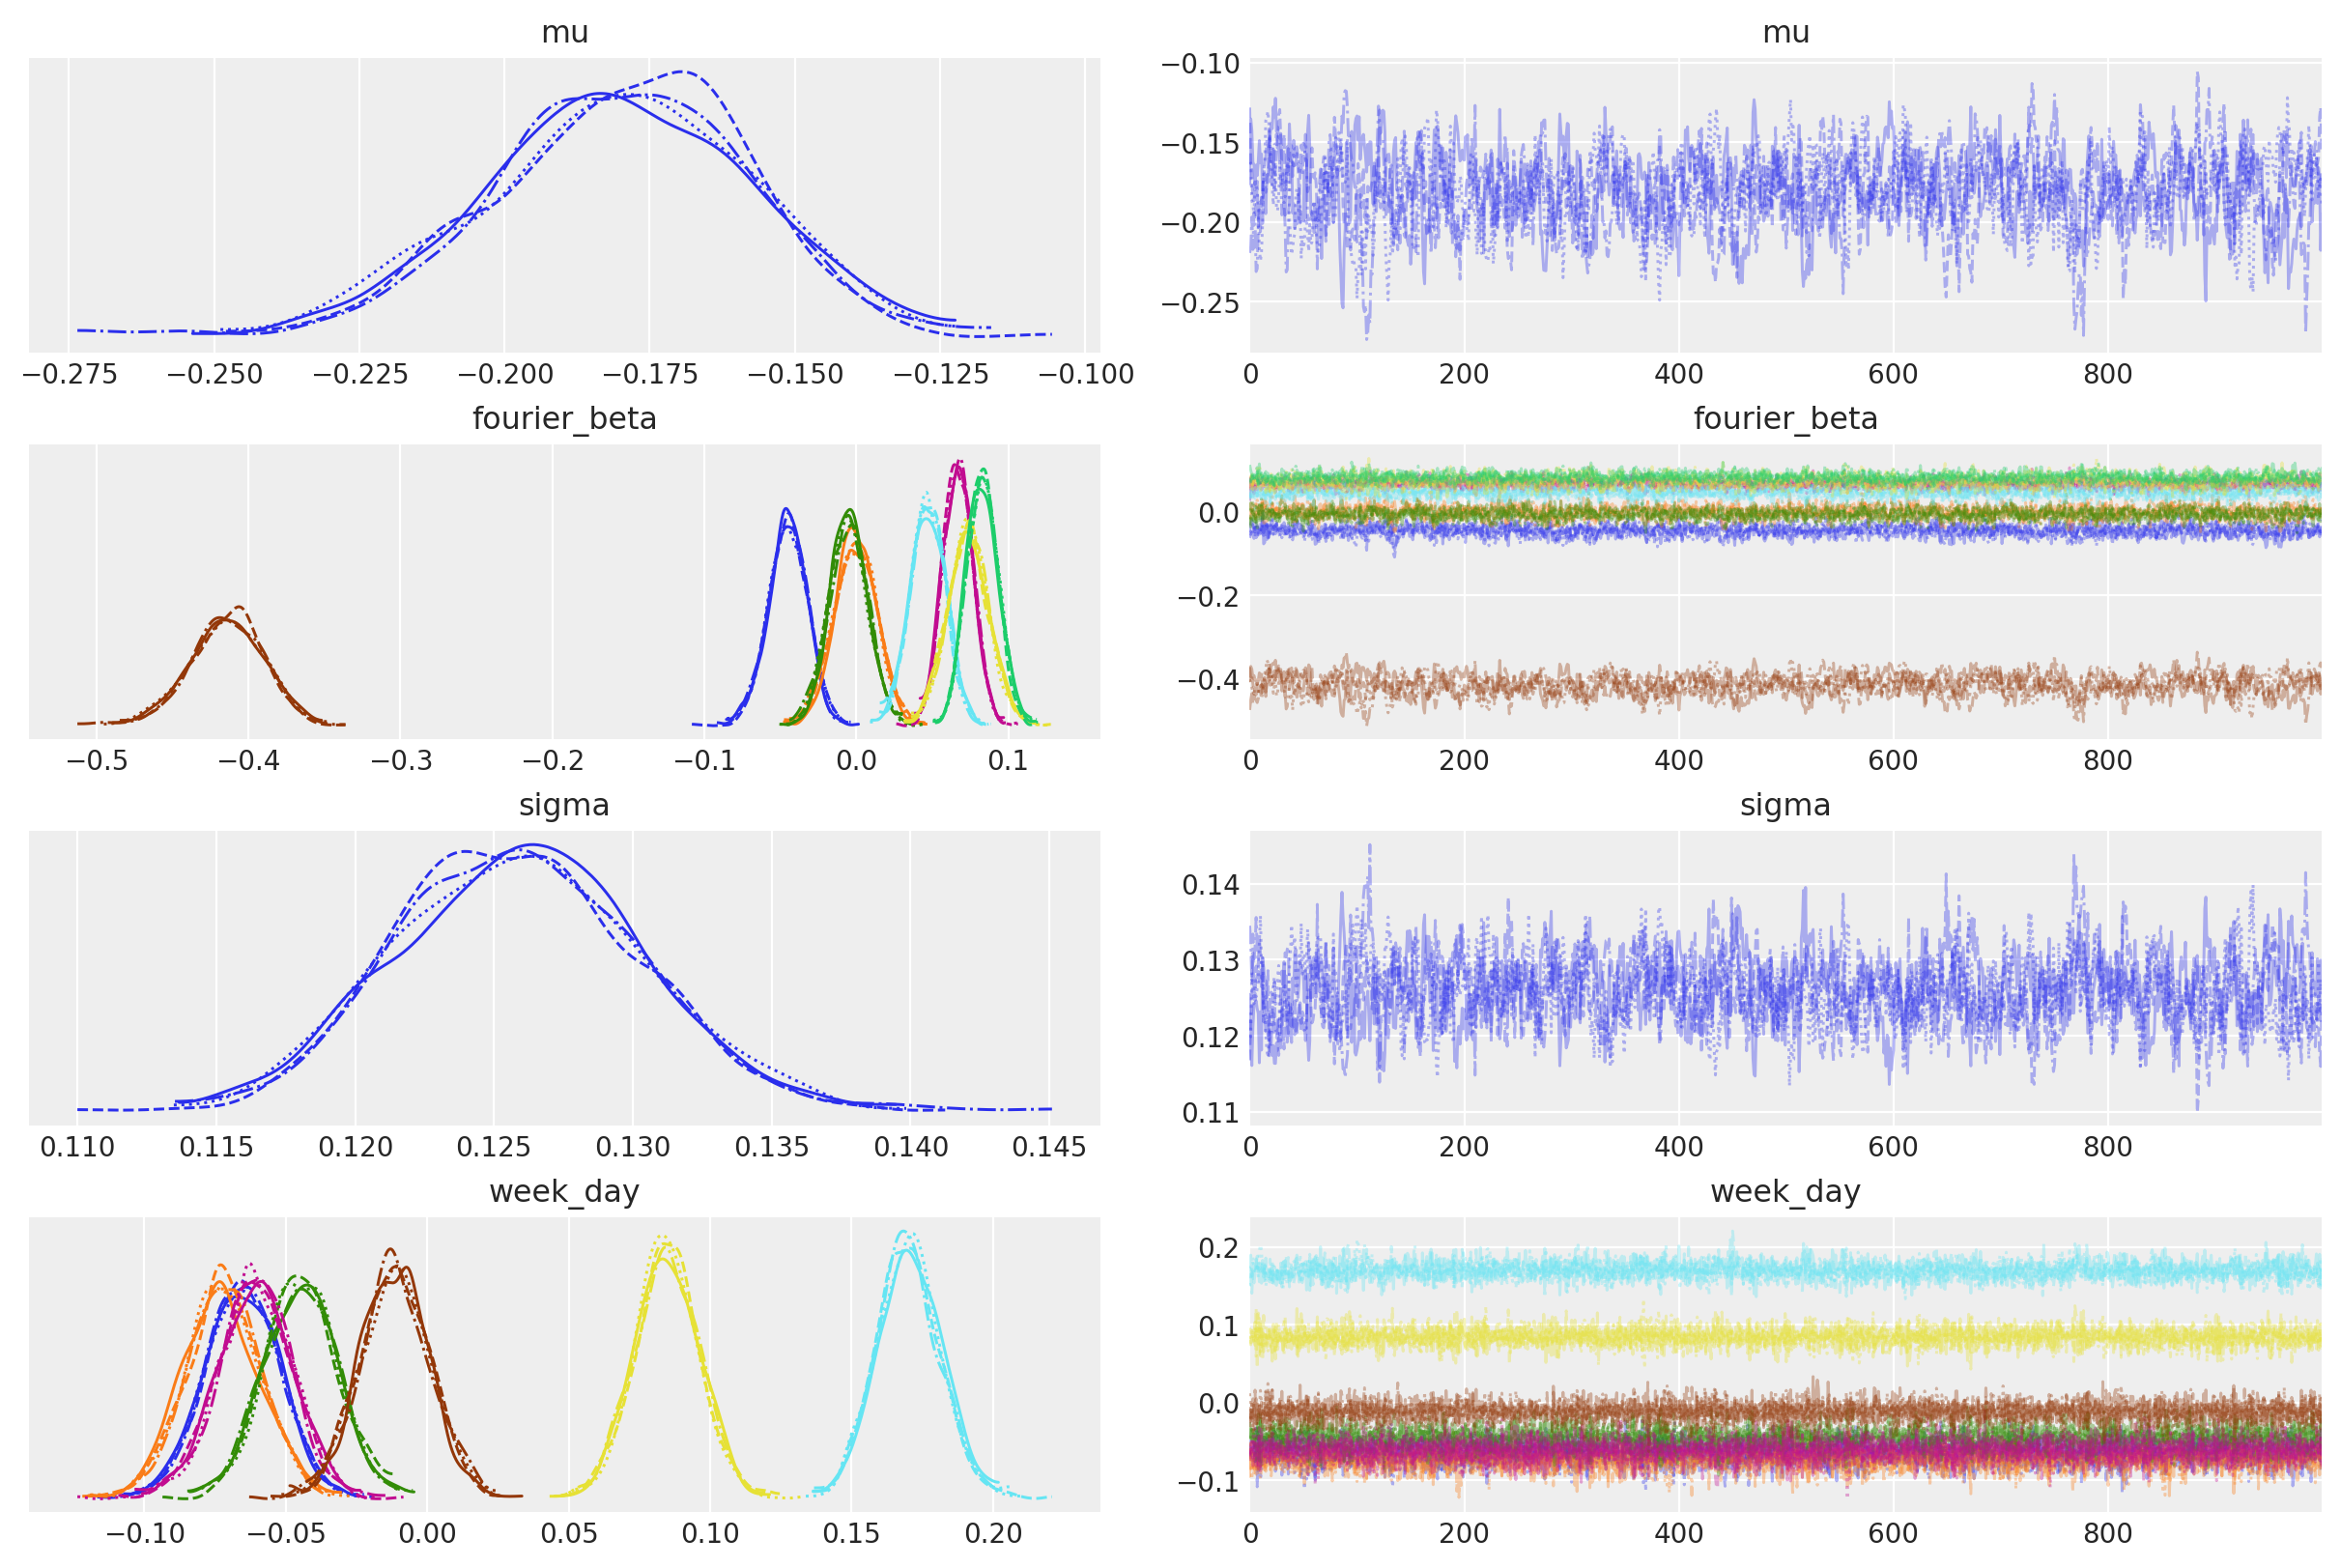

In [19]:
az.plot_trace(trace, var_names=["mu", "fourier_beta", "sigma", "week_day"])
plt.show()

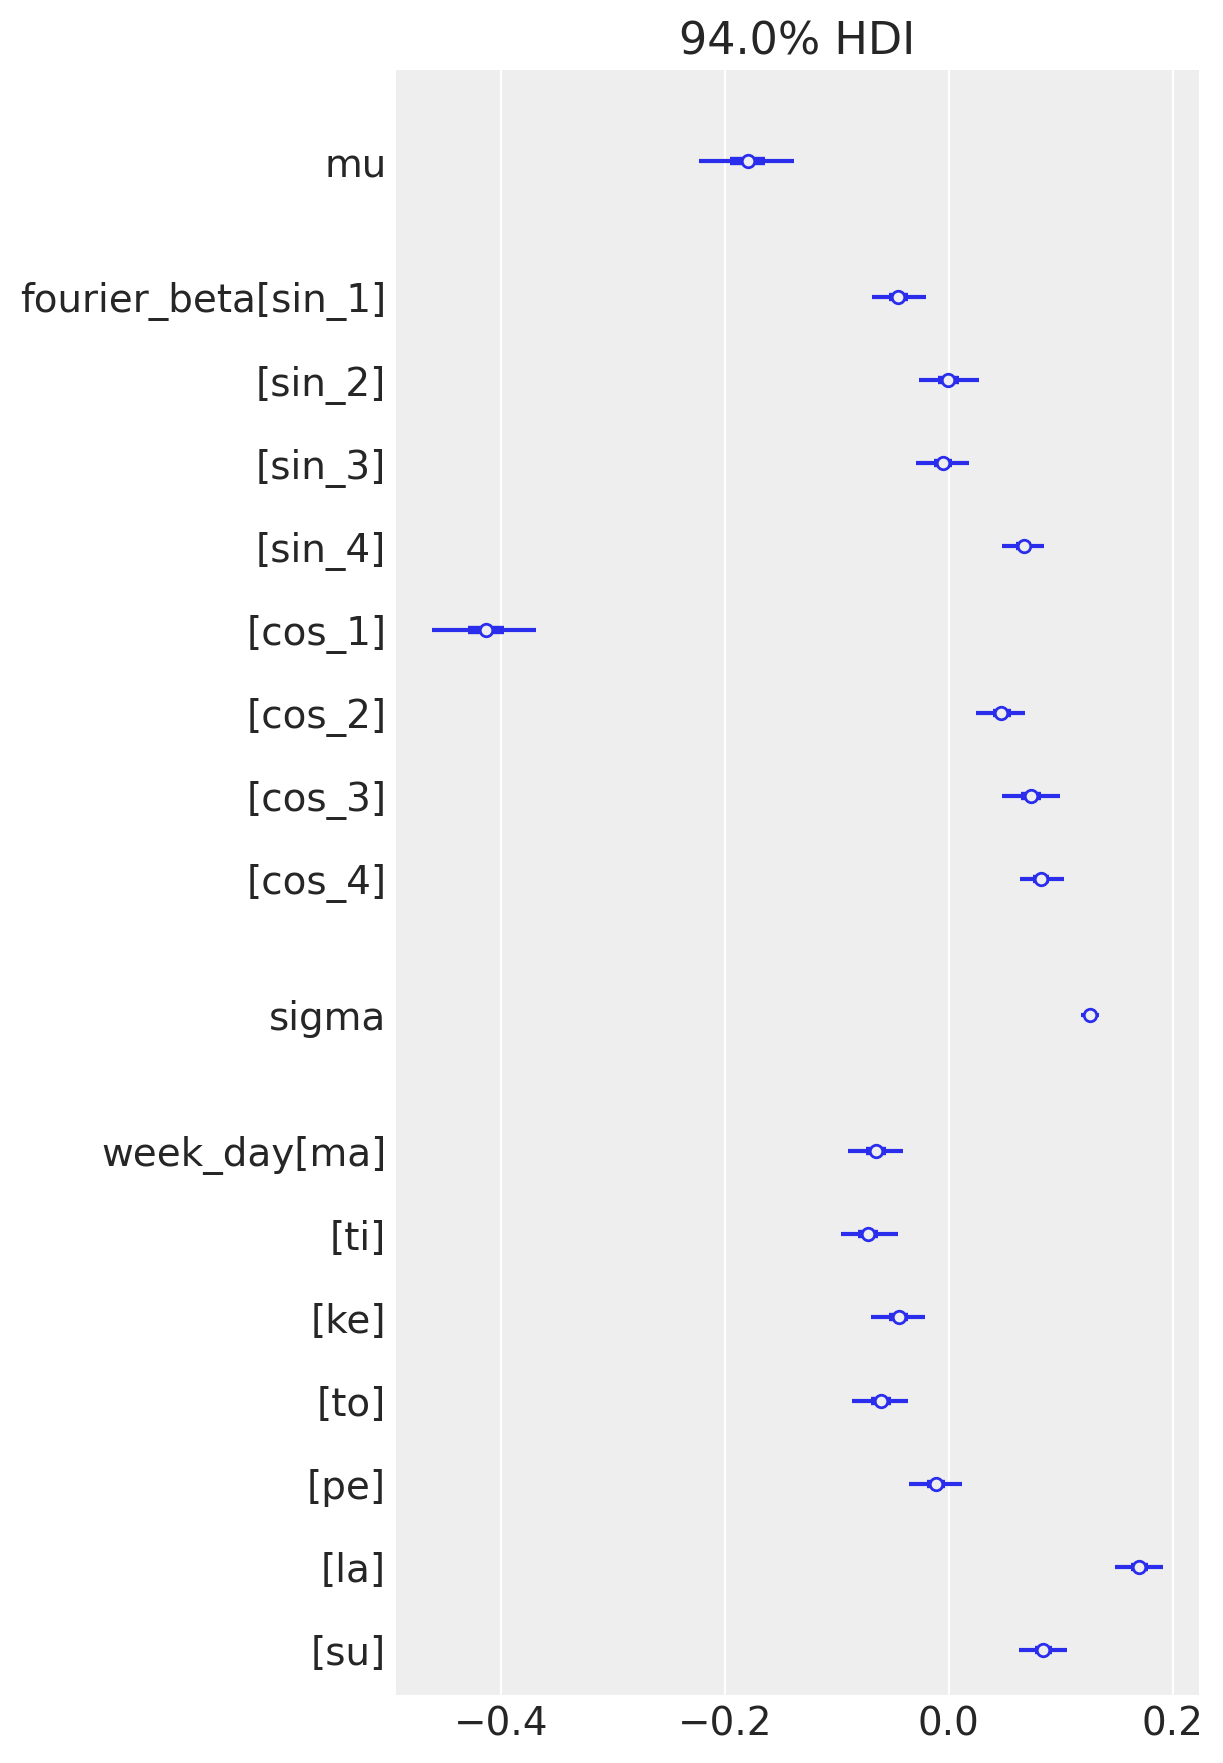

In [20]:
az.plot_forest(
    trace, var_names=["mu", "fourier_beta", "sigma", "week_day"], combined=True
)
plt.show()

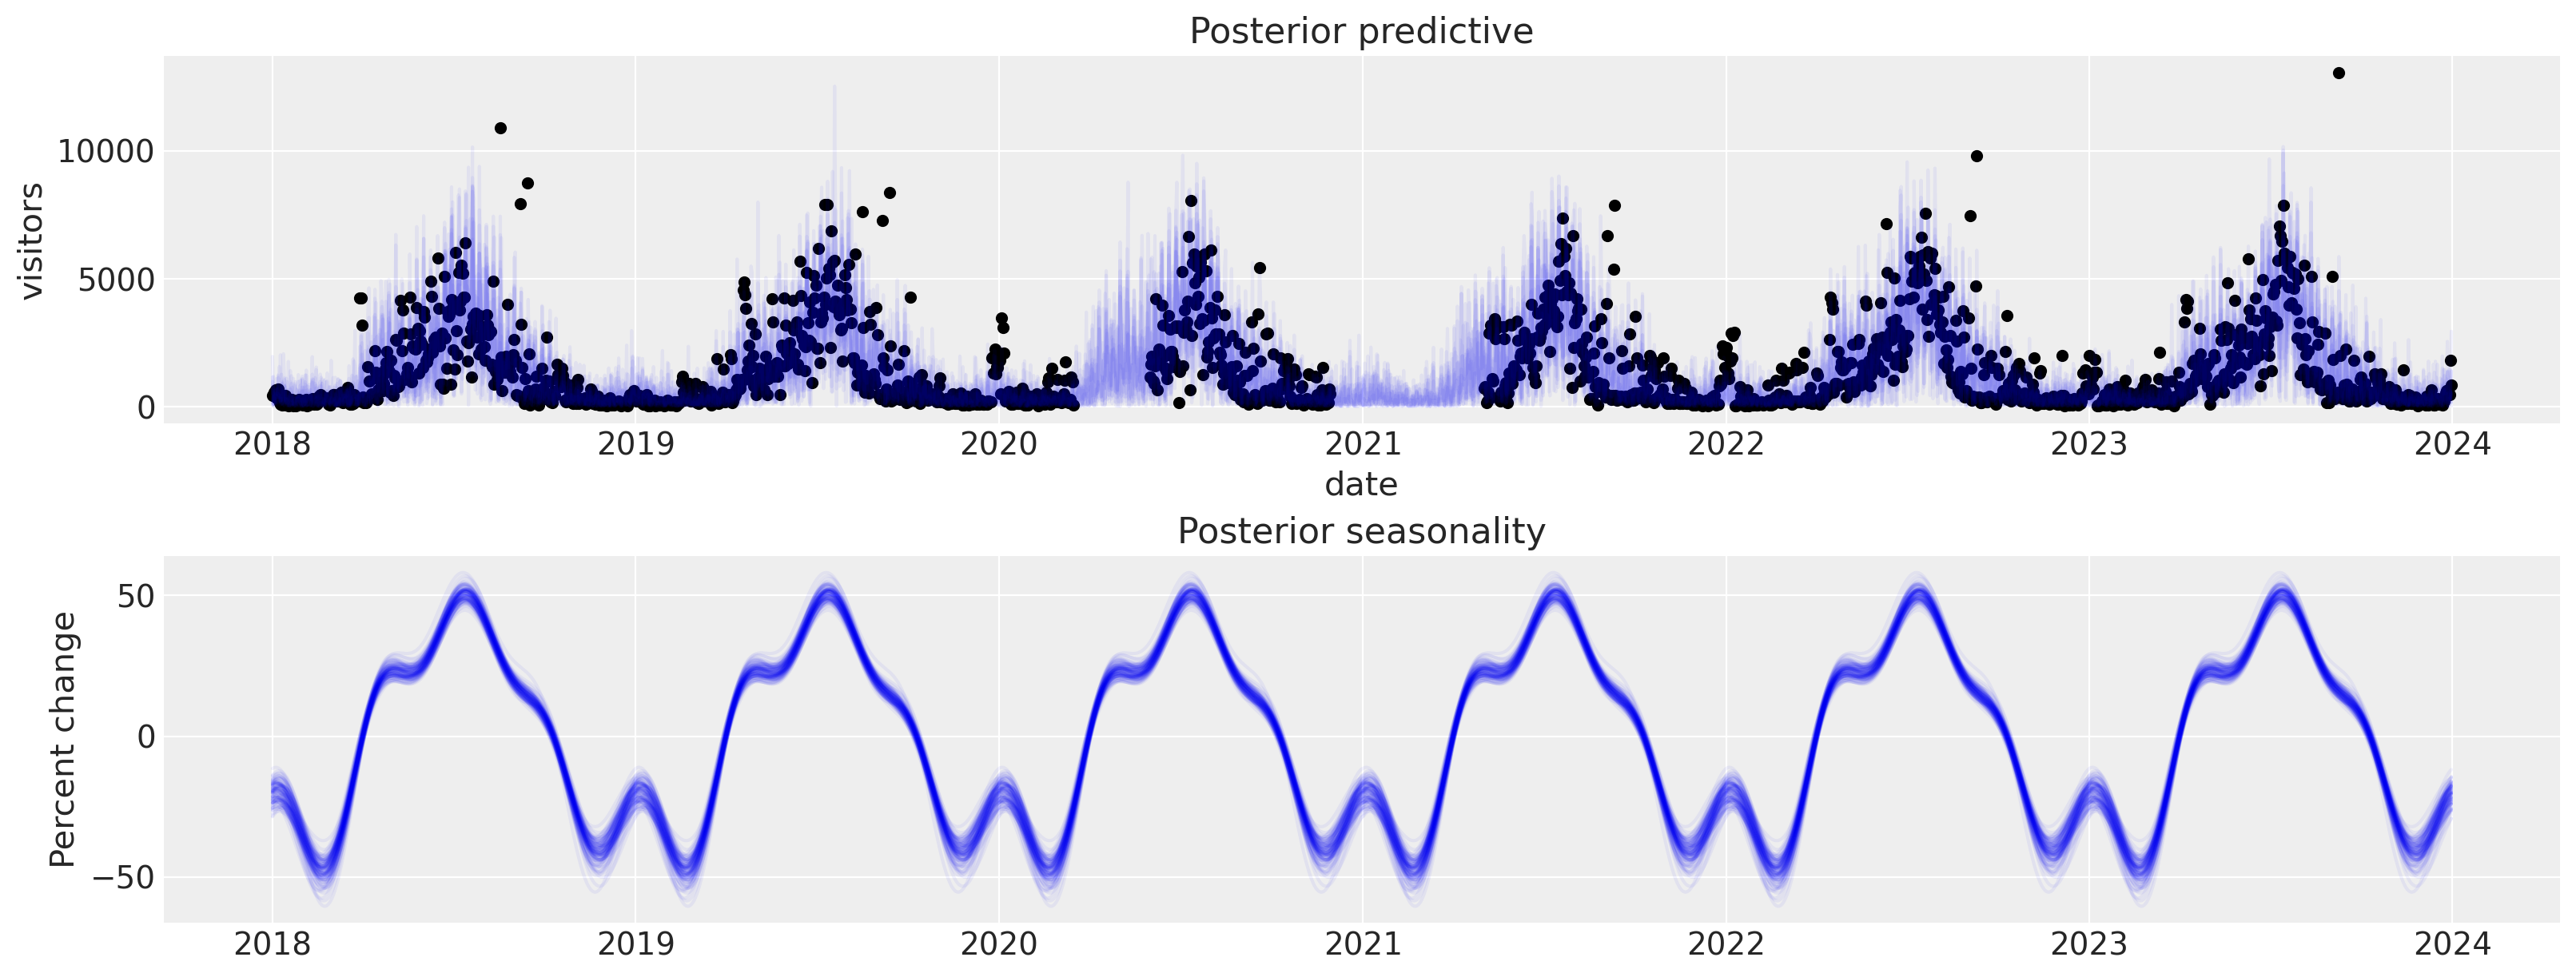

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(16, 6))
ax[0].plot(
    df.index,
    az.extract(post, group="posterior_predictive", num_samples=10)["visitors_obs"]
    * df["visitors"].max(),
    color="blue",
    alpha=0.05,
)
df.reset_index().plot.scatter(x="date", y="visitors", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df.index,
    az.extract(trace, group="posterior", num_samples=100)["seasonality"] * 100,
    color="blue",
    alpha=0.05,
)
ax[1].set_title("Posterior seasonality")
ax[1].set_ylabel("Percent change");